# Otter CT Labeling #

## Data Preprocessing ##

In [1]:
# !pip install flickrapi 
# !pip install opencv-python 
# !pip install split-folders 
# !pip install scikit-image
# !pip install optuna
# !pip install torchinfo
# !pip install pandas 
# !pip install matplotlib
# !pip install lightning
# !pip install scikit-learn
# !pip install optuna-integration
# !pip install wiutils
# !pip install onnx

In [2]:
import os
import gc
import sys
import shutil
import glob 
import random
import requests
import cv2
import flickrapi
import urllib
import pathlib
from pathlib import Path
from PIL import Image, ImageOps, ImageFile
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import splitfolders

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import lightning as L
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms
from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.folder import DatasetFolder
from torchmetrics import Accuracy, Recall, Precision, F1Score
from torch.utils.data import random_split, DataLoader, ConcatDataset
from torchinfo import summary
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from typing import Any, Callable, cast, Dict, List, Optional, Tuple, Union
from collections import Counter

import optuna
import warnings
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from optuna import Trial
from optuna.integration import PyTorchLightningPruningCallback

import onnx

torch.random.manual_seed(4);

N_CLASSES = 10
batch_size = 32
image_size = (224, 224)

### INaturalist Images ###
Searches were performed on INaturalist to get image data for target animals. Searches were filtered by genus/species, then location (Western US and Canada or Utah), then date if needed (most recent included) to narrow number of results, then a random sample was taken from that list. Birds were selected from 9 species/subspecies common to Utah. Search results were downloaded to csv files with links to image URLs. The images are then extracted as follows:

In [3]:
# Adapted from Author: Andrew Shepley "Automated Location Invariant Animal Detection in Camera Trap Images Using Publicly Available Data Sources"
def GetImagesFromURLFile(filename, save_dir, sample_size, start_idx=0):
    #save images in this dir
    if (not os.path.exists(save_dir)):
        os.mkdir(save_dir)
    #csv containing references to images to be downloaded
    raw_file = filename
    
    urls = []
    
    f = open(raw_file, "r", encoding="utf-8")
    for line in f:
        address = line.split(',')[1]
        urls.append(address)

    #discard first URL(header) and take desired sample
    urls.pop(0)
    urls = random.sample(urls, sample_size)
    
    for i, each_url in enumerate(urls):  
        filename = save_dir + "/" + str(i + start_idx) + ".jpg"
        if not urls[i] is None:
            try:
                r = requests.get(each_url, allow_redirects=False)
                open(filename, "wb").write(r.content)
                
                # print("downloaded .... ", filename)
            except:
                print(f'error downloading {each_url}')

In [4]:
# animal_list = ['Beaver', 'Deer', 'Duck', 'Mink', 'Muskrat', 'Raccoon', 'Otter']
# #get 200 images from each animal category
# for animal in animal_list:
#     filename = f'./Data/INat/{animal}.csv'
#     save_dir = f'./Data/Images/{animal}'
#     GetImagesFromURLFile(filename, save_dir, 200)

In [5]:
# bird_list = ['Swallows_Martins', 'Hawk_Eagle', 'Chickadee', 'Crow', 'Finch', 'Heron', 'Robin', 'Sparrow', 'Starling']
# #get 198 images of birds total
# for i, bird in enumerate(bird_list):
#     filename = f'./Data/INat/{bird}.csv'
#     save_dir = f'./Data/Images/Bird'
#     GetImagesFromURLFile(filename, save_dir, 22, i*22) # 9 groups * 22 = 198 images

Additional images of mink and otter were gathered from https://www.wildlifeinsights.org using the same method as above.

In [6]:
# animal_list = ['Mink','Otter']
# #get 30 images from each animal category
# for animal in animal_list:
#     filename = f'./Data/WI/{animal}ExtraCT.csv'
#     save_dir = f'./Data/WIImages/{animal}'
#     GetImagesFromURLFile(filename, save_dir, 30)

### Flickr Images ###
To get images of humans outside and empty outdoor scenes, creative commons images were downloaded from Flickr. **Images retrieved from Flikr were reviewed manually to separate into two categories:**
1. Empty: no animals or humans present
2. Human: humans only present

Artwork and images with both humans and animals were discarded.

In [7]:
# Adapted from Author: Andrew Shepley "Automated Location Invariant Animal Detection in Camera Trap Images Using Publicly Available Data Sources"
# install flickr API if needed
# run with python2 or change source files to run with Python 3 according to instructions at https://github.com/ultralytics/flickr_scraper/issues/8
# "This product uses the Flickr API but is not endorsed or certified by SmugMug, Inc."

Flickr Licenses Info #: https://www.flickr.com/creativecommons/   
* id="0" name="All Rights Reserved"    
* id="1" name="Attribution-NonCommercial-ShareAlike License"    
* id="2" name="Attribution-NonCommercial License"    
* id="3" name="Attribution-NonCommercial-NoDerivs License"    
* id="4" name="Attribution License"
* id="5" name="Attribution-ShareAlike License"   
* id="6" name="Attribution-NoDerivs License"    
* id="7" name="No known copyright restrictions" 
* id="8" name="United States Government Work"   
* id="9" name="Public Domain Dedication (CC0)"   
* id="10" name="Public Domain Mark"  

In [8]:
# # Flickr api access 
# flickr=flickrapi.FlickrAPI('[key]', '[secret]', cache=True)

In [9]:
def ScrapeImages(keywords, save_dir, num_images_per_keyword):
    # params: a list of keywords, a save_directory, and number of images desired per keyword
    
    if (not os.path.exists(save_dir)):
        os.mkdir(save_dir)
    
    for keyword in keywords:
        photos = flickr.walk(text=keyword,tag_mode='all',tags=f"{keyword},-boat,-bone,-footprint,-tracks,-skull,-scat,-fish",license="1,2,3,4,5,6,7,8,9,10",extras='url_c',per_page=500,sort='relevance')
        urls = []
        
        for i, photo in enumerate(photos):
            url = photo.get('url_c')
            urls.append(url)
            if i > num_images_per_keyword:
                break
                
        for i, eachImage in enumerate(urls):  
            filename = save_dir+"/"+keyword+str(i)+".jpg"
            if not urls[i] is None:
                urllib.request.urlretrieve(urls[i], filename)
                try:
                    image = Image.open(filename) 
                    image.save(filename)
                except:
                    print("error: ", filename)

In [10]:
# #humans outside, lots in waders, holding fishing poles, etc.
# num_images_per_keyword = 700
# keywords = ["hiking", "fisherman"]
# save_dir = "./Data/Flickr/Human"
# ScrapeImages(keywords, save_dir, num_images_per_keyword)

In [11]:
# #outside scenes
# num_images_per_keyword = 300
# keywords = ["river", "mountains", "landscape"]
# save_dir = "./Data/Flickr/Empty"
# ScrapeImages(keywords, save_dir, num_images_per_keyword)

In [12]:
#Take only 200 each of human and empty files
def GetFlickrFiles(src_path, dest_path, max_num=200):
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
        
    dirs = [x for x in os.listdir(src_path) if os.path.isdir(os.path.join(src_path, x)) and os.path.dirname(x) != '.ipynb_checkpoints']
    for d in dirs:
        dir_name = os.fsdecode(d)
        dir_path = os.path.join(src_path, dir_name)
        dest_folder = os.path.join(dest_path, dir_name)
        if not os.path.exists(dest_folder):
            os.mkdir(dest_folder)
        files = [x for x in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, x)) and x.endswith('.jpg')]
        num_samples = max_num if (len(files) > (max_num+1)) else (len(files) - 1)                                                                    
        if num_samples > 0:
            for f in random.sample(files, num_samples):
                file_name = os.fsdecode(f)
                shutil.move(os.path.join(dir_path, file_name), os.path.join(dest_folder, f'Flickr{file_name}'))

In [13]:
# src_path = f'./Data/Flickr'
# dest_path = f'./Data/Images'
# GetFlickrFiles(src_path, dest_path, 200)

### Camera Trap Images ###
Download labeled images and slice videos into about three frames per clip. **Because labeling methods were not consistent and some video frame clips were empty, manual review of images was necessary.** Note: images classified as having a bug or insect were labeled as empty. Six images with more than one animal type were discarded.

In [14]:
def ProcessFilesByExtension(source_path, dest_path, frame_gap):
    still_index = 0
    vid_index = 0
    
    folders = os.listdir(source_path)
    for (dirname, dirs, files) in os.walk(source_path):
       for file in files:
          source_file = os.path.join(dirname, file) 
          if file.endswith(".JPG"): 
              f = Path(file)
              new_name = f"{f.stem}-{still_index}.JPG"
              new_file = os.path.join(dirname, new_name)
              os.rename(source_file, new_file)            
              still_index += 1
              shutil.move(new_file, dest_path)
          if file.endswith(".MP4"):
              SaveFrame(source_file, dest_path, frame_gap, vid_index)
              vid_index += 1

In [15]:
def SaveFrame(video_path, save_dir, gap, index):
    name = video_path.split("\\")[-1].split(".")[0]
    cap = cv2.VideoCapture(video_path)
    frame_num = 0
    while True:
        ret, frame = cap.read()
        if (ret == False):
            cap.release()
            os.remove(video_path) 
            break
        save_path = os.path.join(save_dir, f"{name}--{index}-{frame_num}")
        if (frame_num == 0 or frame_num % gap == 0):
            cv2.imwrite(f"{save_path}.jpg", frame)
        frame_num += 1

In [16]:
# source = "./NewImages"
# dest = "./Data/OtterTrapCams/Stills"
# gap = 200
# ProcessFilesByExtension(source, dest, gap)

In [17]:
# # Remove duplicate images and those with very high similarity
# # Adapted from Author: Andrew Shepley "Automated Location Invariant Animal Detection in Camera Trap Images Using Publicly Available Data Sources"
def RemoveDuplicateSimilarImages(src_dir, threshold = 0.7, verbose=True, discard_files=True):
    dirs = os.listdir(src_dir)
    for d in dirs:
        #get dir name and set up lists
        unique = []
        notUnique = []
        folder_name = os.fsdecode(d)
        uniqueImPath = os.path.join(src_dir, f"{folder_name}Unique")
        folder_path = os.path.join(src_dir, d)
        for eachImage in os.listdir(folder_path):
            imageName = os.fsdecode(eachImage)
            imagePath = os.path.join(folder_path, imageName)
            if imageName.endswith('.jpg') and eachImage not in unique and eachImage not in notUnique:
                for eachOtherImage in os.listdir(folder_path):
                    if eachImage != eachOtherImage and eachOtherImage not in unique and eachOtherImage not in notUnique:
                        otherImageName = os.fsdecode(eachOtherImage)
                        otherImagePath = os.path.join(folder_path, otherImageName)
                        if otherImageName.endswith('.jpg') and os.path.exists(otherImagePath):
                            imageA = cv2.imread(imagePath)
                            imageB = cv2.imread(otherImagePath)
                            if imageA.shape == imageB.shape:
                                score = ssim(imageA, imageB, channel_axis=2)
                                if score > threshold:
                                    notUnique.append(eachImage)
                                    if verbose == True:
                                        print(eachImage, "similar to ", eachOtherImage, " with SSIM score: ", score)
                                    break
            if eachImage not in notUnique and os.fsdecode(eachImage).endswith('.jpg'):
                unique.append(eachImage)
                # if verbose == True:
                #     print(eachImage, " unique")
                
        if verbose == True:             
            #print("Unique ", unique)
            print("Not unique ",notUnique)
        
        # discard files that are not unique
        if discard_files == True and len(notUnique)>0:
            for eachImage in notUnique:
                im_path = os.path.join(src_dir, d, eachImage)
                os.remove(im_path)
            print("All non-unique images removed from ", folder_path)

In [18]:
## Used only on Flickr images because this took so long
# RemoveDuplicateSimilarImages('./Datasets/Images/Human', verbose=True, discard_files=True)
# RemoveDuplicateSimilarImages('./Datasets/Images/Empty', verbose=True, discard_files=True)

In [19]:
if os.path.exists('./Data/InfusedImages'):
    shutil.rmtree('./Data/InfusedImages')
if os.path.exists('./Data/ProcessedInfusedImages'):
    shutil.rmtree('./Data/ProcessedInfusedImages')
if os.path.exists('./Data/CT_Test'):
    shutil.rmtree('./Data/CT_Test')

### Create Infused Dataset ###
Infuse non-CT images (91 each class) with up to 15 (leaving at least 15) CT images for datasets.

In [20]:
#Infuse Dataset w/ CT
# move random sample of up to 15 CT images from each CT class and 91 non-CT images into infused folder
def InfuseCTImages(src_path, src_path2, dest_path, max_num_ct=15, num_non_ct=91):
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
        
    dirs = [x for x in os.listdir(src_path) if os.path.isdir(os.path.join(src_path, x)) and os.path.dirname(x) != '.ipynb_checkpoints']
    for d in dirs:
        dir_name = os.fsdecode(d)
        dir_path = os.path.join(src_path, dir_name)
        dest_folder = os.path.join(dest_path, dir_name)
        if not os.path.exists(dest_folder):
            os.mkdir(dest_folder)
        files = [x for x in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, x)) and (x.endswith('.jpg') or x.endswith('.JPG'))]
        num_samples = max_num_ct if (len(files) > (max_num_ct + 1)) else (len(files) - 1)                                                                    
        if num_samples > 0:
            for f in random.sample(files, num_samples):
                file_name = os.fsdecode(f)
                shutil.copy(os.path.join(dir_path, file_name), os.path.join(dest_folder, file_name))
                shutil.move(os.path.join(dest_folder, file_name), os.path.join(dest_folder, f'CT_{file_name}'))

    dirs2 = [x for x in os.listdir(src_path2) if os.path.isdir(os.path.join(src_path2, x)) and os.path.dirname(x) != '.ipynb_checkpoints']
    for d in dirs2:
        dir_name = os.fsdecode(d)
        dir_path = os.path.join(src_path2, dir_name)
        dest_folder = os.path.join(dest_path, dir_name)
        if not os.path.exists(dest_folder):
            os.mkdir(dest_folder)
        files = [x for x in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, x)) and (x.endswith('.jpg') or x.endswith('.JPG'))]  
        num_samples = num_non_ct if len(files) >= num_non_ct else (len(files))
        for f in random.sample(files, num_samples):
            file_name = os.fsdecode(f)
            shutil.copy(os.path.join(dir_path, file_name), os.path.join(dest_folder, file_name))
            shutil.move(os.path.join(dest_folder, file_name), os.path.join(dest_folder, f'{file_name}'))

In [21]:
InfuseCTImages('./Data/OtterTrapCams/Stills', './Data/Images', dest_path='./Data/InfusedImages')

In [22]:
def CTTestImages(src_path, dest_path, max_num_ct=15):
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
        
    dirs = [x for x in os.listdir(src_path) if os.path.isdir(os.path.join(src_path, x)) and os.path.dirname(x) != '.ipynb_checkpoints']
    for d in dirs:
        dir_name = os.fsdecode(d)
        dir_path = os.path.join(src_path, dir_name)
        dest_folder = os.path.join(dest_path, dir_name)
        if not os.path.exists(dest_folder):
            os.mkdir(dest_folder)
        files = [x for x in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, x)) and (x.endswith('.jpg') or x.endswith('.JPG'))]
        num_samples = max_num_ct if (len(files) > (max_num_ct + 1)) else (len(files) - 1)                                                                    
        if num_samples > 0:
            for f in random.sample(files, num_samples):
                file_name = os.fsdecode(f)
                shutil.copy(os.path.join(dir_path, file_name), os.path.join(dest_folder, file_name))
                shutil.move(os.path.join(dest_folder, file_name), os.path.join(dest_folder, f'CT{file_name}'))

In [23]:
CTTestImages('./Data/OtterTrapCams/Stills', './Data/CT_Test')

Externally, I zipped the InfusedImages and Stills Folders for later use.

## START RUN HERE: ##

See zipped image files included with notebook.  

Note that although I have written permission to share animal images and use this dataset for my project, I do not have permission to share the camera trap images of humans publicly.

In [24]:
#unzip image files to your desired directories
# shutil.unpack_archive('InfusedImages.zip', './Data') # folder named InfusedImages
# shutil.unpack_archive('CT_Test.zip', './Data') # folder named Stills

In [25]:
# Run before creating datamodule to remove checkpoint files
if os.path.exists('./checkpoints'):
    shutil.rmtree('./checkpoints')
i = 0
for root, dirs, files in os.walk(os.path.abspath('./Data')):
    for d in dirs:
        if d.startswith('.ipynb'):
            # change new filename each run 
            shutil.move(os.path.join(root, d), f'./checkpoints/{i}-1')
            i += 1

### Create Datamodule and CT test dataloader ###

In [26]:
# Credit to Sunding Wei https://discuss.pytorch.org/t/how-to-resize-and-pad-in-a-torchvision-transforms-compose/71850/4 for the square pad class
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

In [27]:
transform_set = transforms.Compose([
            SquarePad(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # standard for RESNET, VisionTransformer, and ConvNext
        ])

In [28]:
image_size=(224, 224)
class MultiClassDataModule(L.LightningDataModule):
    def __init__(self, data_path='./Data/InfusedImages', output_path='./Data/ProcessedInfusedImages', batch_size=32, transform=transform_set, train_transform=None):
        super().__init__()

        self.batch_size = batch_size
        self.data_path = data_path
        self.output_path = output_path
        self.transform = transform
        self.train_transform = transform if train_transform is None else train_transform
                        
    def prepare_data(self):
        # split each class into train, test, and validation sets
        parent_dir = Path(self.data_path).parents[0]
        splitfolders.ratio(self.data_path, output=self.output_path, ratio=(0.8, 0.1, 0.1))
            
    def setup(self, stage=None):
        self.target_transform = transforms.Lambda(lambda y: torch.tensor([y]).float())

        self.ds_train = datasets.ImageFolder(f"{self.output_path}/train", transform=self.train_transform) 
        self.ds_val = datasets.ImageFolder(f"{self.output_path}/val", transform=self.transform)
        self.ds_test = datasets.ImageFolder(f"{self.output_path}/test", transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=self.batch_size, drop_last=True, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.ds_test, batch_size=self.batch_size)

In [29]:
dm = MultiClassDataModule('./Data/InfusedImages', output_path='./Data/ProcessedInfusedImages')
dm.prepare_data()
dm.setup()

Copying files: 1060 files [00:07, 146.11 files/s]


In [30]:
ds_CTtest = datasets.ImageFolder(root='./Data/CT_Test', transform=transform_set)
dl_CTtest = DataLoader(ds_CTtest, batch_size=32, drop_last=False)

# Data Exploration #

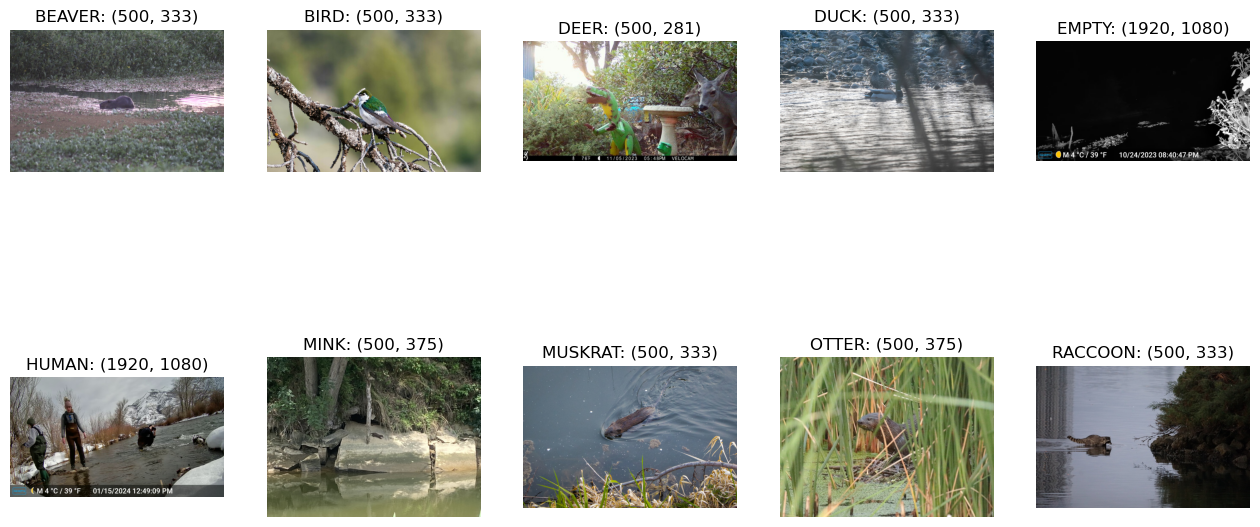

In [31]:
# show some images without transforms (obviously there are some issues with the INaturalist photos, but no filters for animal images only
fig = plt.figure(figsize=(16, 8))

for i, cls in enumerate(['Beaver', 'Bird','Deer','Duck','Empty','Human','Mink','Muskrat','Otter','Raccoon']):
    image_path_list= glob.glob(f"./Data/ProcessedInfusedImages/train/{cls}/*.jpg")
    for j in range(1):
        image_path = image_path_list[j]
        with Image.open(image_path) as f:
            plt.subplot(2, 5, i + j + 1)
            plt.imshow(f) 
            plt.title(f"{cls.upper()}: {f.size}")
            plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


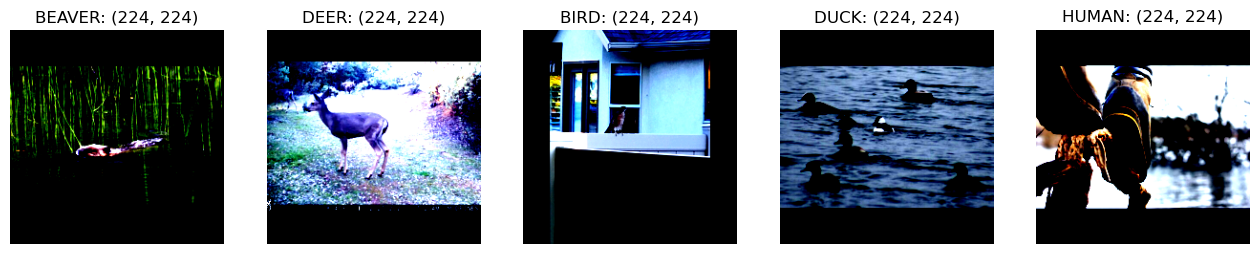

In [32]:
# show some images from train set with transforms applied
ds_train = dm.train_dataloader().dataset

fig = plt.figure(figsize=(16, 9))
for i, j in enumerate(torch.randint(0, 500, size=(1, 5)).squeeze()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(ds_train[j][0].permute(1, 2, 0)) 
    plt.title(f"{ds_train.classes[ds_train[j][1]].upper()}: {tuple(ds_train[j][0].shape[1:])}")
    plt.axis("off")

In [33]:
print(dict(Counter(ds_train.targets)))

{0: 84, 1: 84, 2: 84, 3: 84, 4: 84, 5: 84, 6: 84, 7: 84, 8: 84, 9: 84}


In [34]:
print(dict(Counter(dl_CTtest.dataset.targets)))

{0: 15, 1: 15, 2: 15, 3: 15, 4: 15, 5: 15, 6: 15, 7: 15, 8: 15, 9: 15}


How many from each class in CT test set? #TODO

# Transfer Learning Models #

## RESNET-152 ##

In [35]:
resnet152 = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
resnet152.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [41]:
class RESNETBasedClassifier(L.LightningModule):
    def __init__(self, lr=.001):
        super().__init__()
        self.lr = lr

        self.train_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.test_precision = Precision(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=N_CLASSES, average='macro')
        
        self.pretrained_model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)

        # freeze pre-trained layers
        self.pretrained_model.eval()
        for param in self.pretrained_model.parameters():
            param.requires_grad = False
            
        # replace last linear layer
        self.pretrained_model.fc = nn.Linear(in_features=2048, out_features=N_CLASSES, bias=True)

    def forward(self, x):
        return self.pretrained_model(x)

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(accuracy_lbl, accuracy(y_hat, y), prog_bar=False)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.test_accuracy.update(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", self.test_accuracy(y_hat, y), prog_bar=True)
        self.log("test_precision", self.test_precision(y_hat, y))
        self.log("test_recall", self.test_recall(y_hat, y))
        self.log("test_f1", self.test_f1(y_hat, y))
        return loss

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.log("test_precision", self.test_precision.compute())
        self.log("test_recall", self.test_recall.compute())
        self.log("test_f1", self.test_f1.compute())
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()

    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        y_hat = torch.argmax(logits, dim=1)
        return y_hat
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Hyperparameter tune the RESNET model

In [42]:
def objective(trial, modelclass):

    # Generate the learning rate
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)


    #create model with lr
    model = modelclass(lr)

    early_stop = EarlyStopping(monitor="val_loss", patience=2, mode="min")

    trainer = L.Trainer(
        logger=True,
        enable_checkpointing=True,
        max_epochs=5, 
        callbacks=[early_stop, 
            PyTorchLightningPruningCallback(trial, monitor="val_loss")])
    
    hyperparameters = dict(lr=lr)
    trainer.logger.log_hyperparams(hyperparameters)

    trainer.fit(model, datamodule=dm)

    return trainer.callback_metrics["val_accuracy"].item()

In [43]:
resnet_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

[I 2024-07-19 14:47:51,796] A new study created in memory with name: no-name-ecd51be0-0053-4b95-9ed8-4f773b59a69b


In [44]:
resnet_study.optimize(lambda trial: objective(trial, RESNETBasedClassifier),
    n_trials=10,
    n_jobs=10,
    show_progress_bar=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

Copying files: 0 files [00:00, ? files/s]
Copying files: 104 files [00:00, 1031.08 files/s]
Copying files: 208 files [00:00, 390.55 files/s] 
Copying files: 267 files [00:01, 211.93 files/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Copying files: 0 files [00:00, ? files/s]
Copying files: 304 files [00:01, 194.89 files/s]

Copying files: 8 files [00:00, 76.28 files/s]

Copying files: 23 files [00:00, 118.44 files/s]
Copying files: 333 files [00:01, 180.43 files/s]

Copying files: 40 files [00:00, 140.10 files/s]
Copying files: 357 files [00:01, 185.37 files/s]

Copying files: 60 files [00:00, 162.45 files/s]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU a

Sanity Checking: |                                                                               | 0/? [00:00<…









Copying files: 811 files [00:03, 178.11 files/s]









Copying files: 800 files [00:03, 175.80 files/s]








Copying files: 802 files [00:03, 173.90 files/s]

Copying files: 979 files [00:04, 176.56 files/s]


Copying files: 899 files [00:04, 174.29 files/s]





Copying files: 829 files [00:04, 165.15 files/s]




Copying files: 832 files [00:04, 166.81 files/s]



Copying files: 868 files [00:04, 168.46 files/s]







Copying files: 830 files [00:03, 171.24 files/s]






Copying files: 853 files [00:04, 169.75 files/s]








Copying files: 820 files [00:03, 163.43 files/s]









Copying files: 819 files [00:03, 163.76 files/s]


Copying files: 917 files [00:04, 169.52 files/s]

Copying files: 998 files [00:04, 160.41 files/s]





Copying files: 847 files [00:04, 160.81 files/s]



Copying files: 886 files [00:04, 166.97 files/s]




Copying files: 850 files [00:04, 147.72 files/s]






Copying files: 871 files [00:04, 168.47 files/s]







Copying files: 848 f

Sanity Checking: |                                                                               | 0/? [00:00<…

Copying files: 1060 files [00:05, 187.41 files/s]






Copying files: 1057 files [00:05, 134.33 files/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]








Copying files: 1060 files [00:05, 187.70 files/s]










Copying files: 1043 files [00:05, 135.21 files/s]








Copying files: 1060 files [00:05, 190.30 files/s]
Copying files: 1060 files [00:05, 189.10 files/s]









Copying files: 1059 files [00:05, 146.19 files/s]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Copying files: 1060 files [00:05, 187.76 files/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\janse\miniconda3\envs\torch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.
C:\Users\janse\miniconda3\envs\torch\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (33) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…


  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall      | MulticlassRecall    | 0     
5 | test_f1          | MulticlassF1Score   | 0     
6 | pretrained_model | ResNet              | 58.2 M
---------------------------------------------------------
20.5 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…


  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall      | MulticlassRecall    | 0     
5 | test_f1          | MulticlassF1Score   | 0     
6 | pretrained_model | ResNet              | 58.2 M
---------------------------------------------------------
20.5 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…


  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall      | MulticlassRecall    | 0     
5 | test_f1          | MulticlassF1Score   | 0     
6 | pretrained_model | ResNet              | 58.2 M
---------------------------------------------------------
20.5 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Sanity Checking: |                                                                               | 0/? [00:00<…


  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall      | MulticlassRecall    | 0     
5 | test_f1          | MulticlassF1Score   | 0     
6 | pretrained_model | ResNet              | 58.2 M
---------------------------------------------------------
20.5 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…


  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall      | MulticlassRecall    | 0     
5 | test_f1          | MulticlassF1Score   | 0     
6 | pretrained_model | ResNet              | 58.2 M
---------------------------------------------------------
20.5 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…


  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall      | MulticlassRecall    | 0     
5 | test_f1          | MulticlassF1Score   | 0     
6 | pretrained_model | ResNet              | 58.2 M
---------------------------------------------------------
20.5 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)

  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall   

Sanity Checking: |                                                                               | 0/? [00:00<…

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-07-19 14:55:56,072] Trial 1 finished with value: 0.9879879951477051 and parameters: {'lr': 0.02705084339444001}. Best is trial 1 with value: 0.9879879951477051.
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-07-19 14:56:01,514] Trial 0 finished with value: 0.8678678870201111 and parameters: {'lr': 0.0005873966892666901}. Best is trial 1 with value: 0.9879879951477051.


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-07-19 14:56:42,374] Trial 8 finished with value: 0.6756756901741028 and parameters: {'lr': 0.00010710454728291458}. Best is trial 1 with value: 0.9879879951477051.
[I 2024-07-19 14:56:43,154] Trial 4 finished with value: 0.9969969987869263 and parameters: {'lr': 0.00850246726517383}. Best is trial 4 with value: 0.9969969987869263.
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-07-19 14:56:46,948] Trial 7 finished with value: 0.7087087035179138 and parameters: {'lr': 0.00011178990566352543}. Best is trial 4 with value: 0.9969969987869263.
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-07-19 14:56:54,846] Trial 9 finished with value: 0.7777777910232544 and parameters: {'lr': 0.00023489278858771303}. Best is trial 4 with value: 0.9969969987869263.
`Trainer.fit` stopped: `max_epochs=5` reached.
`Trainer.fit` stopped: `max_epochs=5` reached.
[I 2024-07-19 14:56:55,683] Trial

In [45]:
print("Best params for resnet:")
for key, value in resnet_study.best_params.items():
    print("  {}: {}".format(key, value))

Best params for resnet:
  lr: 0.026534064478148538


Create a model with best found parameters.

In [46]:
resnet_model = RESNETBasedClassifier(resnet_study.best_params["lr"])
early_stop = EarlyStopping(monitor="val_loss", patience=2, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

trainer = L.Trainer(
    max_epochs=5,
    callbacks=[early_stop, checkpoint_callback],
    enable_checkpointing=True,
)
trainer.fit(resnet_model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Copying files: 1060 files [00:00, 1253.71 files/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                | Params
---------------------------------------------------------
0 | train_accuracy   | MulticlassAccuracy  | 0     
1 | val_accuracy     | MulticlassAccuracy  | 0     
2 | test_accuracy    | MulticlassAccuracy  | 0     
3 | test_precision   | MulticlassPrecision | 0     
4 | test_recall      | MulticlassRecall    | 0     
5 | test_f1          | MulticlassF1Score   | 0     
6 | pretrained_model | ResNet              | 58.2 M
---------------------------------------------------------
20.5 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=5` reached.


Test the RESNET model on test dataset and unseen CT dataset.

In [47]:
best_o_resnet_model = RESNETBasedClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(best_o_resnet_model, datamodule=dm)

Copying files: 1060 files [00:00, 1554.86 files/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\janse\miniconda3\envs\torch\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=21` in the `DataLoader` to improve performance.


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9801762104034424     │
│          test_f1          │    0.9786549806594849     │
│         test_loss         │    0.07178390026092529    │
│      test_precision       │    0.9842713475227356     │
│        test_recall        │    0.9757501482963562     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.07178390026092529,
  'test_accuracy': 0.9801762104034424,
  'test_precision': 0.9842713475227356,
  'test_recall': 0.9757501482963562,
  'test_f1': 0.9786549806594849}]

In [48]:
trainer.test(best_o_resnet_model, dataloaders=dl_CTtest)

Copying files: 1060 files [00:00, 1500.79 files/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                                       | 0/? [00:00<…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.943708598613739     │
│          test_f1          │    0.8168766498565674     │
│         test_loss         │     1.234155297279358     │
│      test_precision       │    0.8790592551231384     │
│        test_recall        │    0.8333333730697632     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.234155297279358,
  'test_accuracy': 0.943708598613739,
  'test_precision': 0.8790592551231384,
  'test_recall': 0.8333333730697632,
  'test_f1': 0.8168766498565674}]

In [55]:
predictions = trainer.predict(best_o_resnet_model, dataloaders=dl_CTtest)
predictions

Copying files: 1060 files [00:01, 1000.69 files/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 1, 5, 5,
         1, 1, 1, 1, 1, 1, 2, 2]),
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 1, 1, 1, 4, 4]),
 tensor([5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 9, 5, 1, 5, 1, 1, 5, 5, 5, 5, 3, 5, 5, 5,
         5, 3, 6, 6, 6, 6, 6, 6]),
 tensor([6, 6, 6, 6, 6, 6, 6, 6, 1, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         8, 8, 8, 8, 8, 8, 8, 2]),
 tensor([8, 8, 8, 8, 6, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])]

In [51]:
torch.save(best_o_resnet_model.state_dict(), "./ResNetModel.pth") 

## Save best model. ##

In [52]:
device = torch.device("cpu") 
print("The model will be running on", device, "device\n") 

The model will be running on cpu device



Save best model for use in program.

In [53]:
def convert(model): 
    # set the model to inference mode 
    model.eval() 

    # Let's create a dummy input tensor  
    dummy_input = torch.randn(1, 3, 224, 224, requires_grad=True)

    # Export the model   
    torch.onnx.export(model,         # model being run 
         dummy_input,       # model input (or a tuple for multiple inputs) 
         "Otter2.onnx",       # where to save the model  
         export_params=True,  # store the trained parameter weights inside the model file 
         opset_version=11,    # the ONNX version to export the model to 
         do_constant_folding=True,  # whether to execute constant folding for optimization 
         input_names = ['input'],   # the model's input names 
         output_names = ['output'], # the model's output names 
         dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes 
                                'output' : {0 : 'batch_size'}}) 
    print(" ") 
    print('Model has been converted to ONNX') 

In [54]:
convert(best_o_resnet_model)

 
Model has been converted to ONNX


## VIT ##

In [ ]:
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vit.heads

In [ ]:
class VITBasedClassifier(L.LightningModule):
    def __init__(self, lr=.001):
        super().__init__()
        self.lr = lr

        self.train_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.test_precision = Precision(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=N_CLASSES, average='macro')
        
        self.pretrained_model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

        # freeze pre-trained layers
        self.pretrained_model.eval()
        for param in self.pretrained_model.parameters():
            param.requires_grad = False

        # replace top
        self.pretrained_model.heads = nn.Linear(in_features=768, out_features=N_CLASSES, bias=True)

    def forward(self, x):
        return self.pretrained_model(x)

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(accuracy_lbl, accuracy(y_hat, y), prog_bar=False)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.test_accuracy.update(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", self.test_accuracy(y_hat, y), prog_bar=True)
        self.log("test_precision", self.test_precision(y_hat, y))
        self.log("test_recall", self.test_recall(y_hat, y))
        self.log("test_f1", self.test_f1(y_hat, y))
        return loss

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.log("test_precision", self.test_precision.compute())
        self.log("test_recall", self.test_recall.compute())
        self.log("test_f1", self.test_f1.compute())
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [ ]:
vit_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

In [ ]:
vit_study.optimize(lambda trial: objective(trial, VITBasedClassifier),
    n_trials=10,
    n_jobs=7,
    show_progress_bar=False)

In [ ]:
print("Best params for vit:")
for key, value in vit_study.best_params.items():
    print("  {}: {}".format(key, value))

Create a model with best found parameters.

In [ ]:
o_vit_model = VITBasedClassifier(vit_study.best_params["lr"])
early_stop = EarlyStopping(monitor="val_loss", patience=2, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

trainer = L.Trainer(
    max_epochs=5,
    callbacks=[early_stop, checkpoint_callback],
    enable_checkpointing=True,
)

trainer.fit(o_vit_model, datamodule=dm)

Test the VIT model on test dataset an all unseen CT dataset.

In [ ]:
best_o_vit_model = VITBasedClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(best_o_vit_model, datamodule=dm)

In [ ]:
trainer.test(best_o_vit_model, dataloaders=dl_CTtest)

## ResNext ##

In [ ]:
res_next = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)

In [ ]:
res_next.fc

In [ ]:
class ResNextBasedClassifier(L.LightningModule):
    def __init__(self, lr=.001):
        super().__init__()
        self.lr = lr

        self.train_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.test_precision = Precision(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=N_CLASSES, average='macro')
        
        self.pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)

        self.pretrained_model.eval()
        for param in self.pretrained_model.parameters():
            param.requires_grad = False

        self.pretrained_model.fc = nn.Linear(in_features=2048, out_features=N_CLASSES, bias=True)

    def forward(self, x):
        return self.pretrained_model(x)

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(accuracy_lbl, accuracy(y_hat, y), prog_bar=False)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.test_accuracy.update(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", self.test_accuracy(y_hat, y), prog_bar=True)
        self.log("test_precision", self.test_precision(y_hat, y))
        self.log("test_recall", self.test_recall(y_hat, y))
        self.log("test_f1", self.test_f1(y_hat, y))
        return loss

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.log("test_precision", self.test_precision.compute())
        self.log("test_recall", self.test_recall.compute())
        self.log("test_f1", self.test_f1.compute())
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        
    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=self.lr)

In [ ]:
resnext_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

In [ ]:
resnext_study.optimize(lambda trial: objective(trial, ResNextBasedClassifier),
    n_trials=10,
    n_jobs=10,
    show_progress_bar=False)

In [ ]:
print("Best params for resnext:")
for key, value in resnext_study.best_params.items():
    print("  {}: {}".format(key, value))

Create a model with best found parameters.

In [ ]:
o_resnext_model = ResNextBasedClassifier(resnext_study.best_params["lr"])

early_stop = EarlyStopping(monitor="val_loss", patience=2, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

trainer = L.Trainer(
    max_epochs=5,
    callbacks=[early_stop, checkpoint_callback],
    enable_checkpointing=True,
)

trainer.fit(o_resnext_model, datamodule=dm)

Test ResNext tuned model on test dataset and unseen CT dataset.

In [ ]:
best_o_resnext_model = ResNextBasedClassifier.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(best_o_resnext_model, datamodule=dm)

In [ ]:
trainer.test(best_o_resnext_model, dataloaders=dl_CTtest)

## Fully Connected NN ##


In [48]:
shutil.rmtree('./lightning_logs') #run if need to ensure enough memory for trials

In [ ]:
class FeedForwardNN(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr

        self.train_accuracy = Accuracy(task='multiclass', num_classes=N_CLASSES)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=N_CLASSES)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
        self.test_precision = Precision(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_recall = Recall(task="multiclass", num_classes=N_CLASSES, average='macro')
        self.test_f1 = F1Score(task="multiclass", num_classes=N_CLASSES, average='macro')

        self.nn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(224*224*3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.nn(x)

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(accuracy_lbl, accuracy(y_hat, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()
        
    def test_step(self, batch, batch_idx):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.test_accuracy.update(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", self.test_accuracy(y_hat, y), prog_bar=True)
        self.log("test_precision", self.test_precision(y_hat, y))
        self.log("test_recall", self.test_recall(y_hat, y))
        self.log("test_f1", self.test_f1(y_hat, y))
        return loss

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.log("test_precision", self.test_precision.compute())
        self.log("test_recall", self.test_recall.compute())
        self.log("test_f1", self.test_f1.compute())
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Create a Feed Forward NN model.

In [ ]:
ff_study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

In [ ]:
ff_study.optimize(lambda trial: objective(trial, FeedForwardNN),
    n_trials=10,
    n_jobs=2,
    show_progress_bar=False)

In [ ]:
print("Best params for ff:")
for key, value in ff_study.best_params.items():
    print("  {}: {}".format(key, value))

In [ ]:
ff_model = FeedForwardNN(ff_study.best_params["lr"])

early_stop = EarlyStopping(monitor="val_loss", patience=2, mode="min")
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

trainer = L.Trainer(
    logger=True,
    max_epochs=5,
    callbacks=[early_stop, checkpoint_callback],
    enable_checkpointing=True,
)

trainer.fit(ff_model, datamodule=dm)

Test tuned Feed Forward NN Model on test dataset and unseen CT images dataset.

In [ ]:
best_o_ff_model = FeedForwardNN.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(best_o_ff_model, datamodule=dm)

In [ ]:
trainer.test(best_o_ff_model, dataloaders=dl_CTtest)

In [ ]:
resnet_model = None
best_o_resent_model = None
o_cn_model = None
o_cn_model = None
ff_model = None
best_o_ff_model = None
o_vit_model = None
best_o_vit_model = None
gc.collect()